<a href="https://colab.research.google.com/github/muhammadthaufik10315/Deeplearning_Klasifikasi_Wajah_Moi_3-Efficientnet-/blob/main/Ujicoba%20Epoach%2030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install -U --pre efficientnet
from efficientnet.tfkeras import EfficientNetB1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

In [36]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [37]:
path = "/content/drive/MyDrive/split_data/suku9/train"
lists_dir = os.listdir(path)
categories = []
file_name = []
for folder in lists_dir:
    files = os.listdir(path +"/"+folder)
    for file in files:
        path_file = path + "/" + folder + "/" + file
        file_name.append(path_file)
        categories.append(folder)

df = {"image": file_name,"categories": categories}
data = pd.DataFrame(df, index = None)
data = data.sample(frac=1)
data.head(5)

,image,categories
25,/content/drive/MyDrive/split_data/suku9/train/...,moi
39,/content/drive/MyDrive/split_data/suku9/train/...,moi
160,/content/drive/MyDrive/split_data/suku9/train/...,moi
317,/content/drive/MyDrive/split_data/suku9/train/...,nonmoi
77,/content/drive/MyDrive/split_data/suku9/train/...,moi


In [38]:
path_datatest = "/content/drive/MyDrive/split_data/suku9/test"
lists_dir_datatest = os.listdir(path_datatest)
categories_datatest = []
file_name_datatest = []
for folder in lists_dir_datatest:
    files = os.listdir(path_datatest +"/"+folder)
    for file in files:
        path_file = path_datatest + "/" + folder + "/" + file
        file_name_datatest.append(path_file)
        categories_datatest.append(folder)

df_datatest = {"image": file_name_datatest,"categories":categories_datatest}
data_datatest = pd.DataFrame(df_datatest, index = None)
data_datatest = data_datatest.sample(frac=1)
nb_samples=data_datatest.shape[0]
data_datatest

,image,categories
16,/content/drive/MyDrive/split_data/suku9/test/n...,nonmoi
33,/content/drive/MyDrive/split_data/suku9/test/n...,nonmoi
93,/content/drive/MyDrive/split_data/suku9/test/m...,moi
23,/content/drive/MyDrive/split_data/suku9/test/n...,nonmoi
29,/content/drive/MyDrive/split_data/suku9/test/n...,nonmoi
...,...,...
55,/content/drive/MyDrive/split_data/suku9/test/m...,moi
87,/content/drive/MyDrive/split_data/suku9/test/m...,moi
18,/content/drive/MyDrive/split_data/suku9/test/n...,nonmoi
34,/content/drive/MyDrive/split_data/suku9/test/n...,nonmoi


<Axes: >

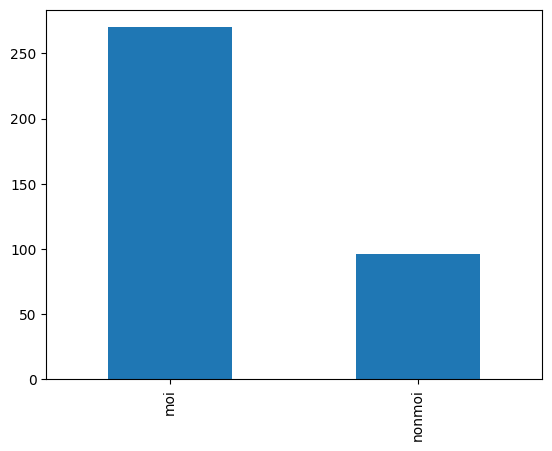

In [39]:
data['categories'].value_counts().plot.bar()

In [40]:
total_dataset=len(data_datatest)+len(data)
"Total dataset Suku :{} Suku".format(total_dataset)

'Total dataset Suku :466 Suku'

In [41]:
data["categories"] = data["categories"].replace({0: 'moi', 1: 'nonmoi'})

In [42]:
train_df, validate_df = train_test_split(data, test_size=0.10, random_state=20)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

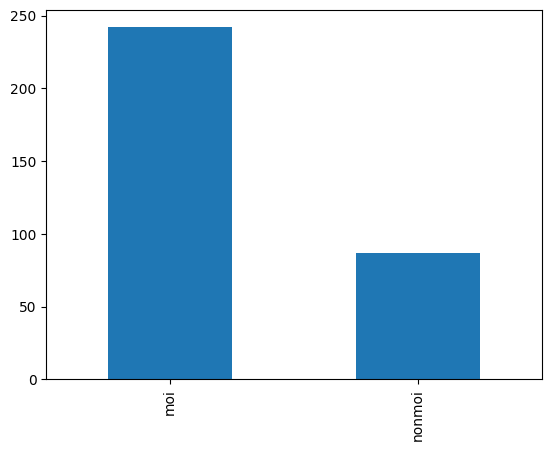

In [43]:
train_df['categories'].value_counts().plot.bar()

In [44]:
len(train_df)

329

<Axes: >

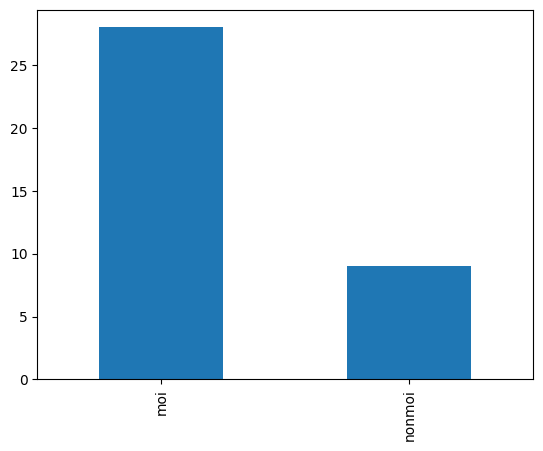

In [45]:
validate_df['categories'].value_counts().plot.bar()

In [46]:
len(validate_df)

37

In [47]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

In [48]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.1,
    vertical_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 329 validated image filenames belonging to 2 classes.


In [49]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory=path,
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 37 validated image filenames belonging to 2 classes.


In [50]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    dataframe=example_df,
    dir=path,
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


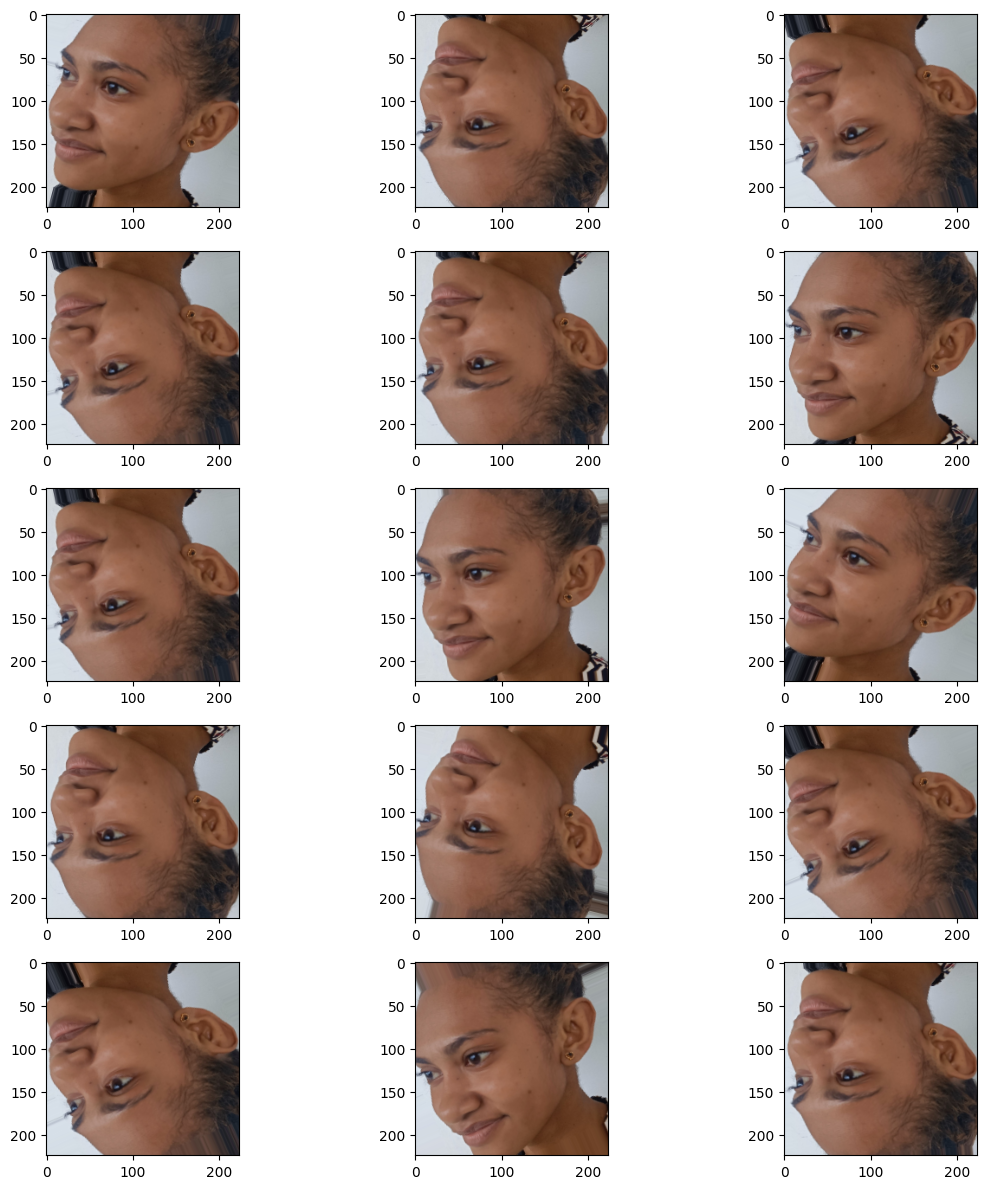

In [51]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [52]:
base_model = EfficientNetB1(input_shape=(224,224,3),
                                 include_top=False,
                                 weights='noisy-student')

In [53]:
for layer in base_model.layers:
    layer.trainable=False

In [54]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(640,kernel_size=(1,1)))
model.add(Flatten())
model.add(Dense(320,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(tensorflow.keras.layers.ReLU())
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

In [55]:
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b1 (Functiona  (None, 7, 7, 1280)        6575232   
 l)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 640)         819840    
                                                                 
 flatten_1 (Flatten)         (None, 31360)             0         
                                                                 
 dense_2 (Dense)             (None, 320)               10035520  
                                                                 
 batch_normalization_1 (Bat  (None, 320)               1280      
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 320)              

In [56]:
epochs=30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/30
10/10 [==============================] - 34s 2s/step - loss: 1.2340 - accuracy: 0.6835 - val_loss: 2.5355 - val_accuracy: 0.6875
Epoch 2/30
10/10 [==============================] - 10s 964ms/step - loss: 0.6828 - accuracy: 0.7781 - val_loss: 1.9577 - val_accuracy: 0.6875
Epoch 3/30
10/10 [==============================] - 9s 872ms/step - loss: 0.4266 - accuracy: 0.8249 - val_loss: 3.7561 - val_accuracy: 0.4375
Epoch 4/30
10/10 [==============================] - 7s 723ms/step - loss: 0.4162 - accuracy: 0.8531 - val_loss: 1.5942 - val_accuracy: 0.6875
Epoch 5/30
10/10 [==============================] - 9s 892ms/step - loss: 0.3460 - accuracy: 0.8586 - val_loss: 1.1623 - val_accuracy: 0.5938
Epoch 6/30
10/10 [==============================] - 8s 757ms/step - loss: 0.2883 - accuracy: 0.8822 - val_loss: 0.9309 - val_accuracy: 0.7500
Epoch 7/30
10/10 [==============================] - 9s 854ms/step - loss: 0.2265 - accuracy: 0.8788 - val_loss: 0.7579 - val_accuracy: 0.7812
Epoch 8

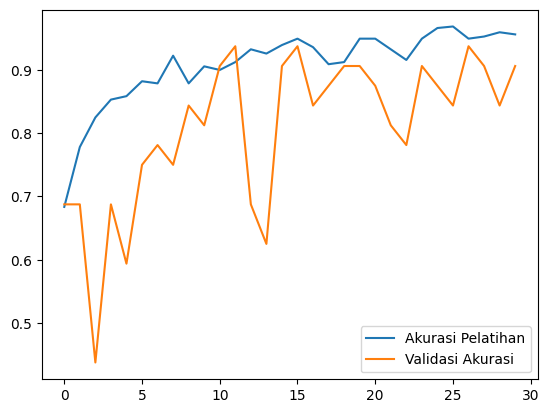

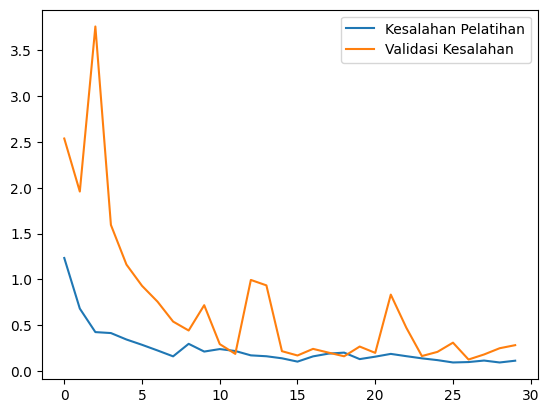

In [57]:
plt.plot(history.history["accuracy"],label="Akurasi Pelatihan")
plt.plot(history.history["val_accuracy"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [58]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    dataframe=data_datatest,
    dir=path_datatest,
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


In [59]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

4/4 [==============================] - 3s 173ms/step


In [60]:
predicted_classes=np.argmax(predict,axis=1)
predicted_classes

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0])

In [61]:
true_classes=np.array(data_datatest['categories'].replace(['moi','nonmoi',],[0,1]))
true_classes

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0])

In [62]:
class_labels=['0','1']
class_labels

['0', '1']

In [63]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[48,  2],
       [16, 34]])

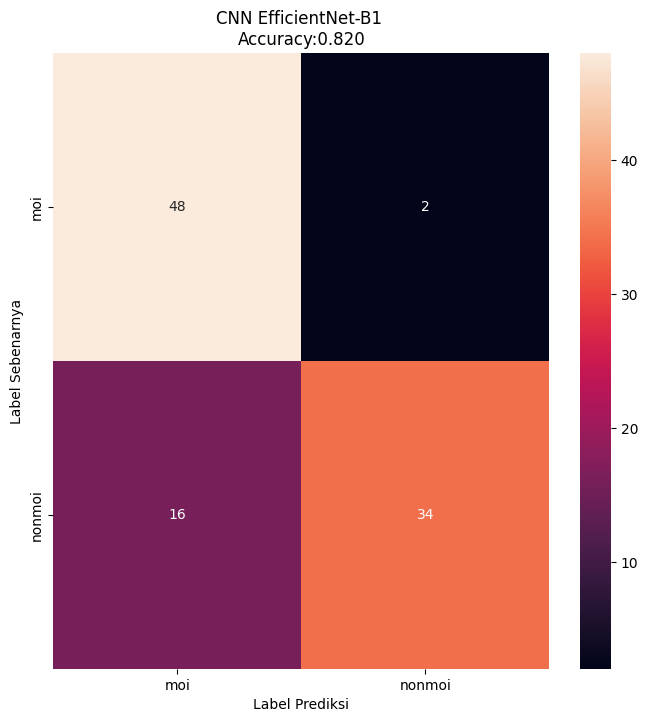

In [64]:
cm_df = pd.DataFrame(cm,
                     index = ['moi','nonmoi'],
                     columns = ['moi','nonmoi'])

plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('CNN EfficientNet-B1 \nAccuracy:{0:.3f}'.format(accuracy_score(true_classes, predicted_classes)))
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.show()

In [65]:
report=metrics.classification_report(true_classes, predicted_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



In [66]:
model.save('geeksforgeeks.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
